Parse CIEMSS datacube.

In [98]:
import json

initialsData = {}
parametersData = {}
variableRunsData = {}
runsData = []

with open(f'./simulation-run-data/ciemss_datacube.json', 'r') as f:
    # content = f.read()
    # print(content)
    fileData = json.load(f)
    for data in fileData:
        scenarioData = fileData[data]
        scenarioParameters = scenarioData['parameters']
        scenarioIC = scenarioData['initials']
        scenarioDescription = scenarioData['description']
        print(scenarioDescription)

        parametersData[scenarioDescription] = scenarioParameters
        parametersData[scenarioDescription] = scenarioIC;
        for i in scenarioData['output']:
            stateVarData = scenarioData['output'][i]
            stateVarName = stateVarData['name']
            if stateVarData['name'] not in variableRunsData:
                variableRunsData[stateVarData['name']] = []
            variableRunsData[stateVarName] = variableRunsData[stateVarName] + stateVarData['value']
            # print(stateVarName)
            # print(len(variableRunsData[stateVarName]))

        # just for infected
        # for j in range(len(scenarioData['output']['2']['value'])):
        #     runsData.append(scenarioData['output']['2']['value'][j])

print(variableRunsData.keys())

no_intervention
intervened_parameter
intervened_rate
ramping_intervention
encouragement_interventions
dict_keys(['S', 'V', 'I', 'R'])


Assume that we start with a list of run trajectories extracted earlier. First make the full size images for each state variable including all scenarios.

S


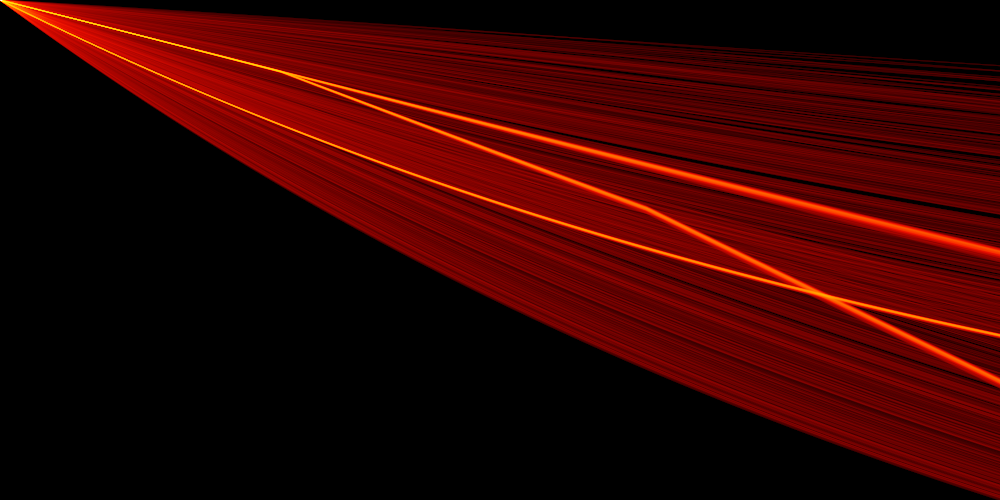

V


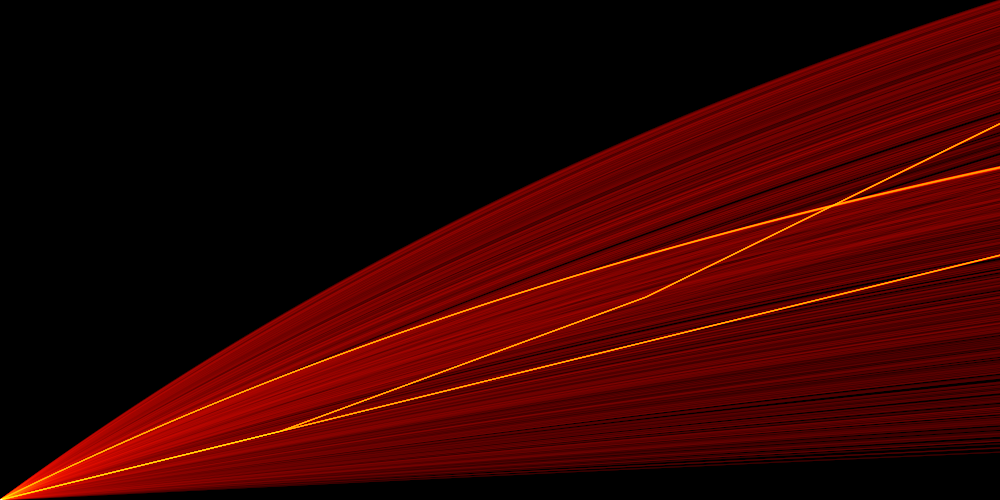

I


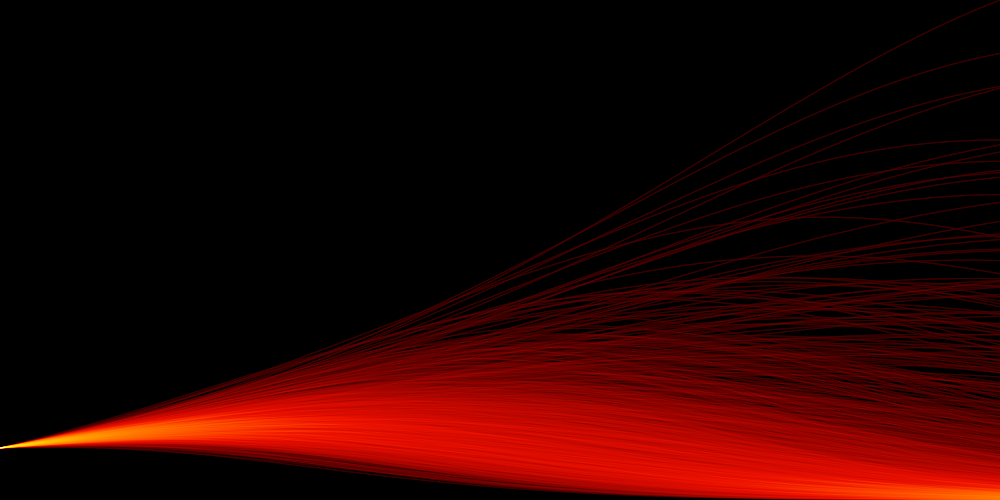

R


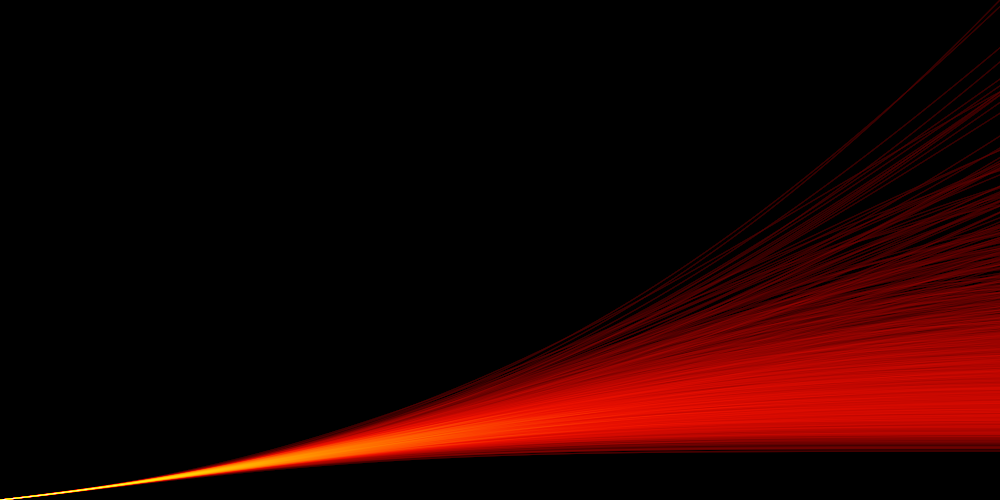

In [99]:
import pandas as pd, numpy as np
import datashader as ds
import datashader.transfer_functions as tf
import datashader.utils as utils
import colorcet as cc
from IPython.display import display

for variableName in variableRunsData:
    df = pd.DataFrame(variableRunsData[variableName])
    points = len(df.axes[1])
    time = np.linspace(0, 1, points)
    cvs = ds.Canvas(plot_height=500, plot_width=1000)
    agg = cvs.line(df, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=1)

    img = tf.shade(agg, cmap=cc.fire, how='log')
    img = tf.set_background(img, color='black')
    utils.export_image(img, variableName)
    print(variableName)
    display(img)

The create the thumbnails which will go into nodes (as previews of a sort).

S


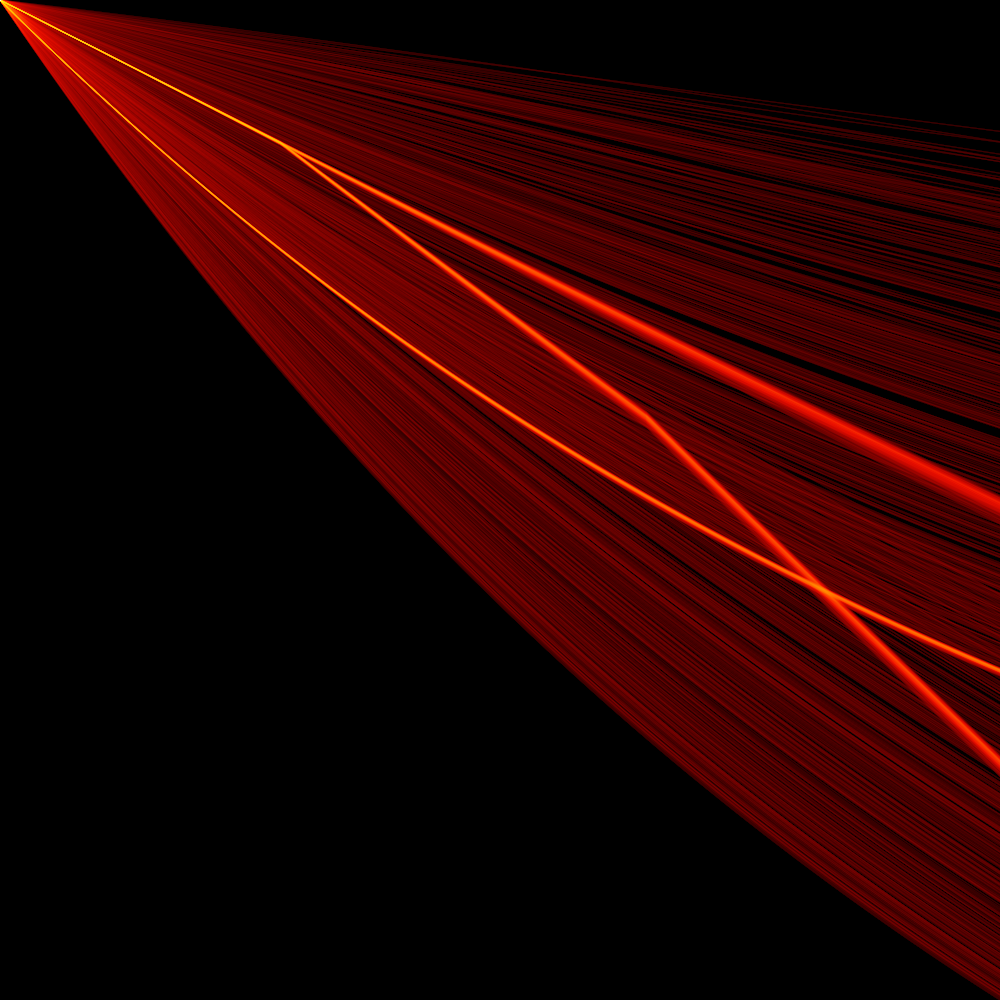

V


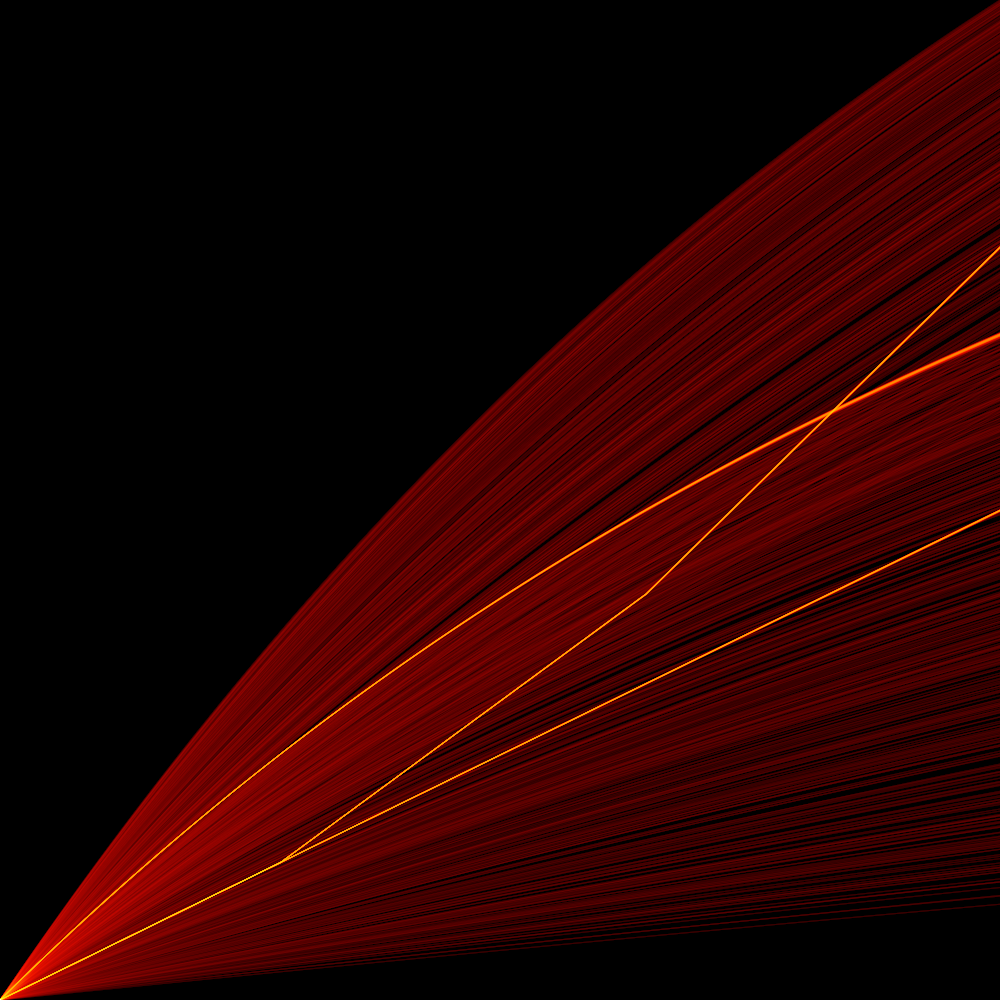

I


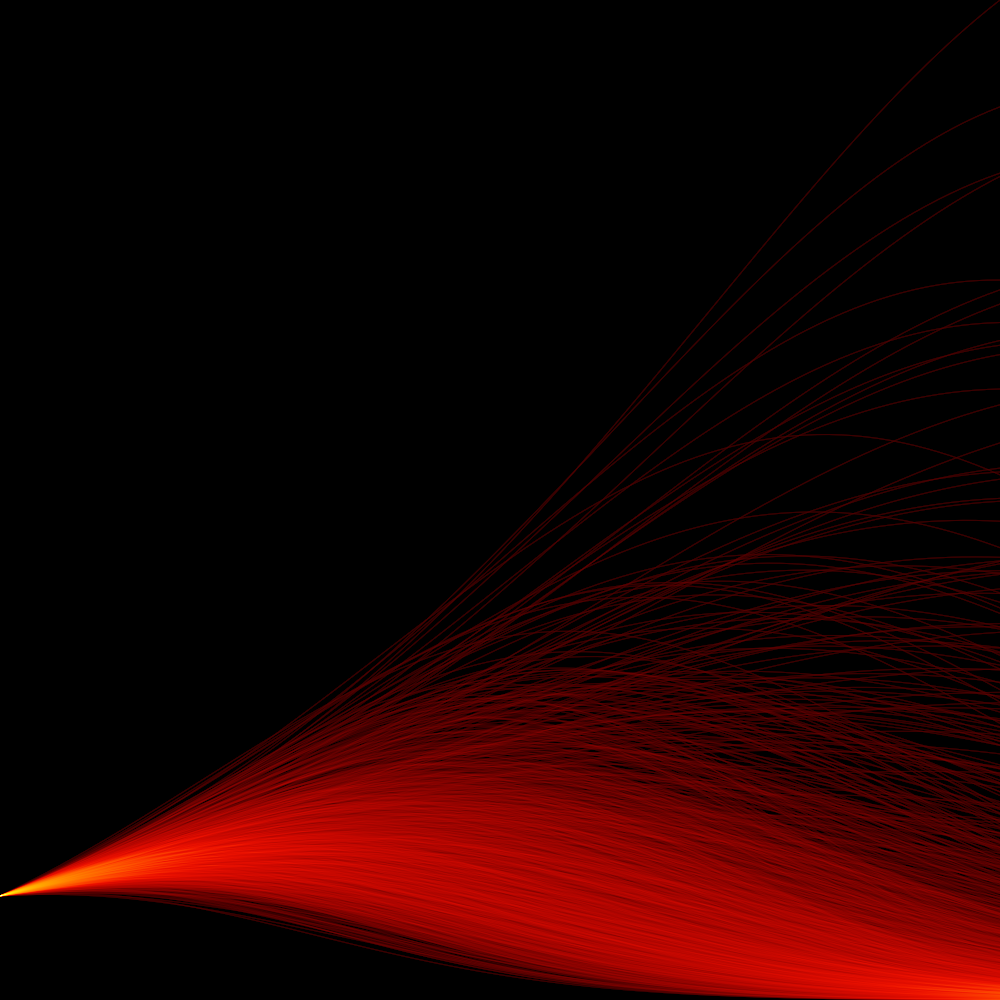

R


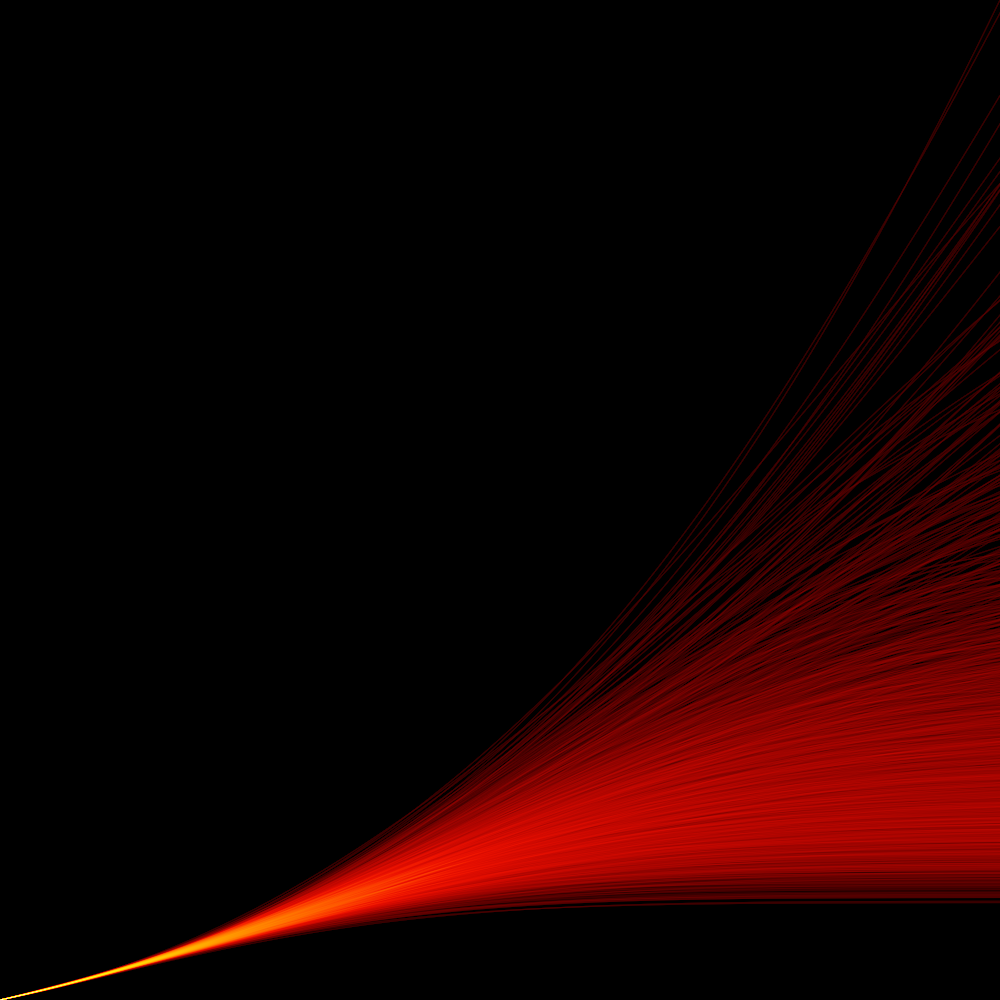

In [100]:
for variableName in variableRunsData:
    df = pd.DataFrame(variableRunsData[variableName])
    points = len(df.axes[1])
    time = np.linspace(0, 1, points)
    cvs = ds.Canvas(plot_height=1000, plot_width=1000)
    agg = cvs.line(df, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=1)

    img = tf.shade(agg, cmap=cc.fire, how='log')
    img = tf.set_background(img, color='black')
    utils.export_image(img, variableName + '_thumb')
    print(variableName)
    display(img)

Calculate the aggregate trajectory for each scenario and plot aggregate trajectories against each other.

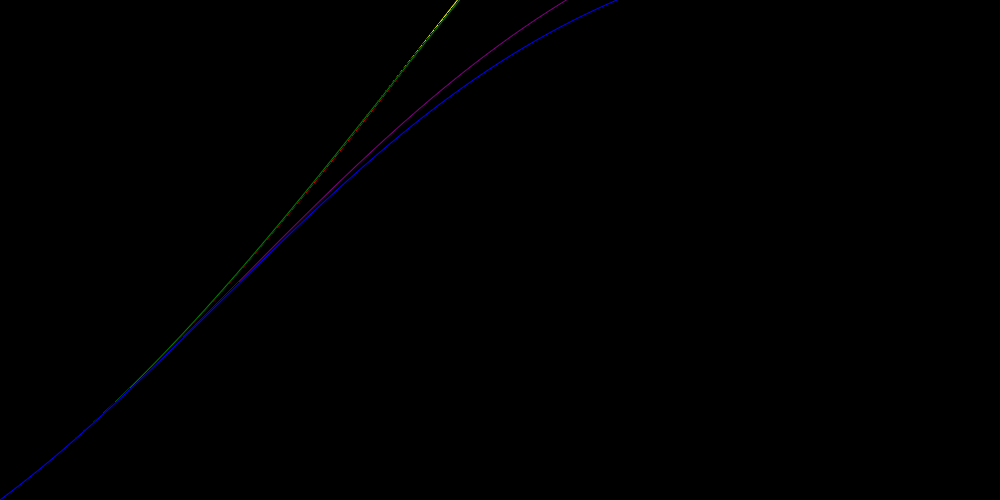

In [101]:
dfAggregates = [
    pd.DataFrame([df.iloc[0:500].mean()]),
    pd.DataFrame([df.iloc[500:1000].mean()]),
    pd.DataFrame([df.iloc[1000:1500].mean()]),
    pd.DataFrame([df.iloc[1500:2000].mean()]),
    pd.DataFrame([df.iloc[2000:2500].mean()])
]

x_range = [0, 1]
y_range = [0, 950]
cvs = ds.Canvas(plot_height=500, plot_width=1000, x_range=x_range, y_range=y_range)

aggs = []
for i in range(5):
    points = len(dfAggregates[i].axes[1])
    time = np.linspace(0, 1, points)
    aggs.append(cvs.line(dfAggregates[i], x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=1))

colors = ["red", "purple", "yellow","green", "blue"]
imgs = [tf.shade(aggs[i], cmap=['black', colors[i]]) for i in range(5)]
img = tf.stack(*imgs)
img = tf.set_background(img, color='black')
# utils.export_image(img, 'aggregate_chart')
img

Demonstrate the utility of selecting a portion of the previous datacube, in this case only the "No Intervention" scenario. Note that more work needs to be done on the blending method to make it more readable and useful.

Experiment with different rendering techniques for highlighting a subset of the lines on the graph. Issues/features that need to be addressed or supported using any chosen rendering technique include:

- Anti-aliasing
- Prevent the subset from completely obscuring all the data from the faded set
- Ensure that the data remains faithfully represented (gaps in lines, etc.)
- Reliable determination of set of origin of data point

Build data objects required to render the highlighted subset graph for use in rendering technique testing. As well provide a function which converts DataShader image objects into PIL image objects.

In [102]:
# import all libraries used for experiments below
import os
from PIL import Image
import math
import numpy as np
import matplotlib
%load_ext cython

# select data
df = pd.DataFrame(variableRunsData['I'])

# manually set the x/y range to prevent the autorange from using different scales and throwing errors
x_range = [0, 1]
y_range = [0, 950]

dfAll = df
pointsAll = len(dfAll.axes[1])
timeAll = np.linspace(0, 1, pointsAll)

selectedStart = 0
selectedEnd = 500

# build faded graph data
dfUnselected = df.iloc[np.r_[0:selectedStart, selectedEnd:2500]]
print(dfUnselected)
pointsUnselected = len(dfUnselected.axes[1])
timeUnselected = np.linspace(0, 1, pointsUnselected)

# build highlighted graph data
dfSelected = df.iloc[selectedStart:selectedEnd]
# dfSelection = df.loc[df[80] <= 0.008]
pointsSelected = len(dfSelected.axes[1])
timeSelected = np.linspace(0, 1, pointsSelected)

#########################################################
# define common functions

def clamp_uint8(value):
    return np.uint8(sorted((0, value, 255))[1])

# convert datashader image object to PIL image object using PNG as an intermediate
def ds_to_pil_rgba(img):
    utils.export_image(img, '_tmp')
    img = Image.open('_tmp.png', 'r') 
    os.remove("_tmp.png")
    return img

# strips alpha channel out of a numpy rgba data array
def np_rgba_to_rgb(img_rgba):
    img_rgb = np.empty([img_rgba.shape[0], img_rgba.shape[1], 3], dtype=img_rgba.dtype)
    for row in range(0, img_rgba.shape[0]):
        for col in range(0, img_rgba.shape[1]):
            for p in range(0, 3):
                img_rgb[row][col][p] = img_rgba[row][col][p]
    return img_rgb

def np_uint8_to_float_color(img_uint8):
    img_float = np.empty([img_uint8.shape[0], img_uint8.shape[1], 3], dtype=np.float32)
    for row in range(0, img_uint8.shape[0]):
        for col in range(0, img_uint8.shape[1]):
            for p in range(0, img_uint8.shape[2]):
                img_float[row][col][p] = img_uint8[row][col][p] / 255
    return img_float

def np_float_to_uint8_color(img_float):
    img_uint8 = np.empty([img_float.shape[0], img_float.shape[1], 3], dtype=np.uint8)
    for row in range(0, img_float.shape[0]):
        for col in range(0, img_float.shape[1]):
            for p in range(0, img_float.shape[2]):
                img_uint8[row][col][p] = math.floor(img_float[row][col][p] * 255)
    return img_uint8

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
             0           1           2           3           4           5   \
500   96.309998   99.767876  103.157310  106.464157  109.674507  112.774704   
501   96.309998   97.681122   98.909798   99.984421  100.896507  101.639915   
502   96.309998  100.367523  104.400223  108.390648  112.321533  116.175865   
503   96.309998   98.306755  100.179199  101.923126  103.534744  105.010674   
504   96.309998   99.551628  102.730881  105.832672  108.842758  111.747597   
...         ...         ...         ...         ...         ...         ...   
2495  96.309998   99.264618  102.173592  105.029602  107.825233  110.553024   
2496  96.309998   98.904831  101.348000  103.627625  105.732559  107.652527   
2497  96.309998   99.037025  101.602715  103.986946  106.171959  108.142014   
2498  96.309998   99.180244  101.934029  104.553581  107.022728  109.326637   
2499  96.309998   99.530945  102.727890  105.884453

The following produces a highlighted graph with NO anti-aliasing as a baseline for comparison.

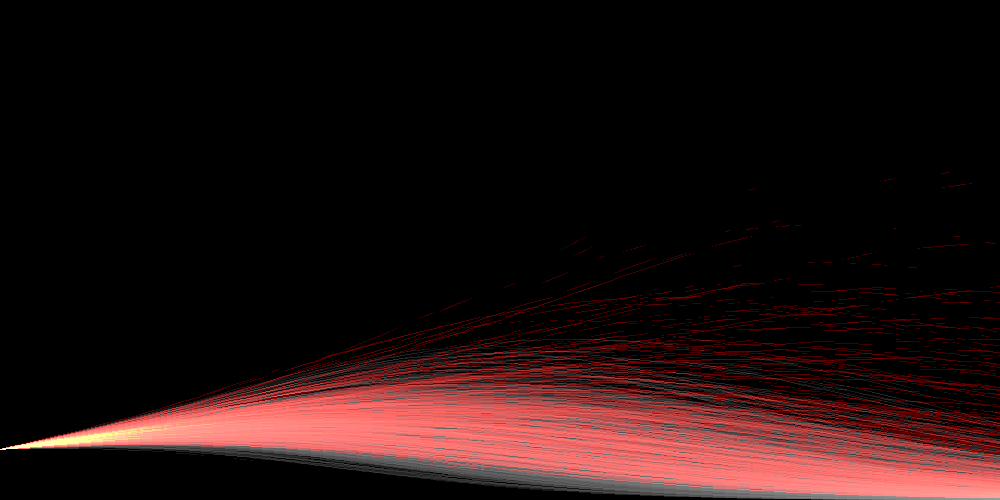

In [103]:
# build faded graph
cvs = ds.Canvas(plot_height=500, plot_width=1000, x_range=x_range, y_range=y_range)
aggFaded = cvs.line(dfUnselected, x=timeUnselected, y=list(range(pointsUnselected)), agg=ds.count(), axis=1, line_width=0)

# build highlighted graph
cvs = ds.Canvas(plot_height=500, plot_width=1000, x_range=x_range, y_range=y_range)
aggSelection = cvs.line(dfSelected, x=timeSelected, y=list(range(pointsSelected)), agg=ds.count(), axis=1, line_width=0)

# combine images
imgStack = [tf.shade([aggFaded, aggSelection][i], cmap=[['black', 'grey', 'lightgrey'], cc.fire][i], how='log', min_alpha=0) for i in range(2)]
img = tf.stack(*imgStack, how='add')
img = tf.set_background(img, color='black')
img

The following produces a highlighted graph using additive stacking of seperate anti-aliased images (using built in datashader anti-aliasing).

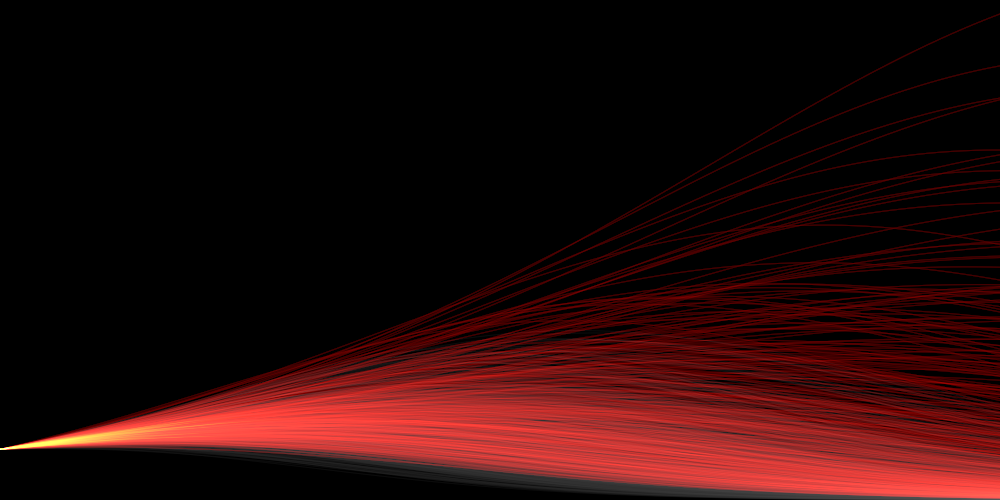

In [104]:
# build faded graph
cvs = ds.Canvas(plot_height=500, plot_width=1000, x_range=x_range, y_range=y_range)
aggFaded = cvs.line(dfUnselected, x=timeUnselected, y=list(range(pointsUnselected)), agg=ds.count(), axis=1, line_width=1)

# build highlighted graph
cvs = ds.Canvas(plot_height=500, plot_width=1000, x_range=x_range, y_range=y_range)
aggSelection = cvs.line(dfSelected, x=timeSelected, y=list(range(pointsSelected)), agg=ds.count(), axis=1, line_width=1)

# combine images
imgStack = [tf.shade([aggFaded, aggSelection][i], cmap=[['black', 'grey'], cc.fire][i], how='log', min_alpha=0) for i in range(2)]
img = tf.stack(*imgStack, how='add')
img = tf.set_background(img, color='black')
img

The following produces a graph using supersampling for anti-aliasing with datashader anti-aliasing turned on and using over stacking.

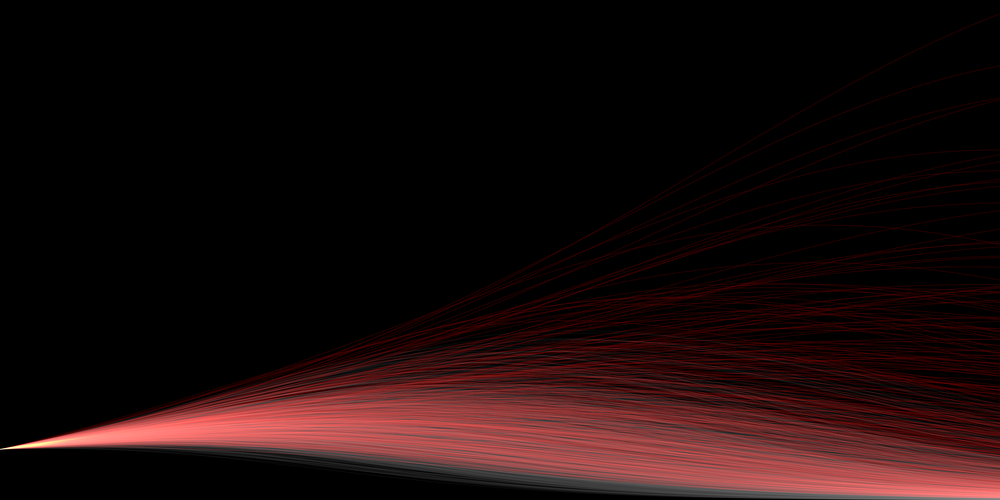

In [105]:
supersamplingRatio = 3

# build faded graph
cvs = ds.Canvas(plot_height=500 * supersamplingRatio, plot_width=1000 * supersamplingRatio, x_range=x_range, y_range=y_range)
aggFaded = cvs.line(dfUnselected, x=timeUnselected, y=list(range(pointsUnselected)), agg=ds.count(), axis=1, line_width=1)

# build highlighted graph
cvs = ds.Canvas(plot_height=500 * supersamplingRatio, plot_width=1000 * supersamplingRatio, x_range=x_range, y_range=y_range)
aggSelection = cvs.line(dfSelected, x=timeSelected, y=list(range(pointsSelected)), agg=ds.count(), axis=1, line_width=1)

# combine images
imgStack = [tf.shade([aggFaded, aggSelection][i], cmap=[['black', 'grey', 'lightgrey'], cc.fire][i], how='log', min_alpha=0) for i in range(2)]
img = tf.stack(*imgStack, how='add')
img = tf.set_background(img, color='black')

# convert to PIL image for downsampling
img = ds_to_pil_rgba(img)
img = img.resize((1000, 500), resample=Image.Resampling.LANCZOS)
img

The following produces a graph with orthogonal colour mappings, in an effort to improve how well you can see the individual colour components and as well as the mix between the two.

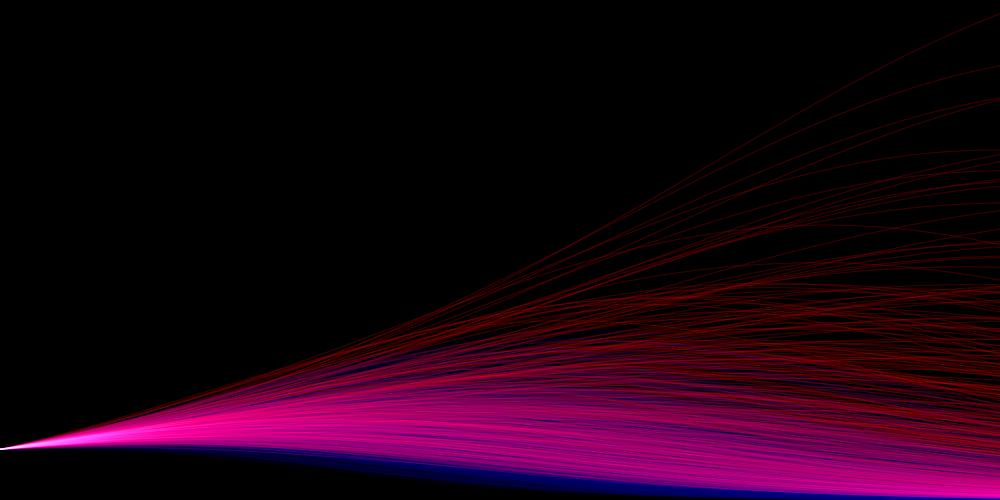

In [106]:
# build faded graph
cvs = ds.Canvas(plot_height=500, plot_width=1000, x_range=x_range, y_range=y_range)
aggFaded = cvs.line(dfUnselected, x=timeUnselected, y=list(range(pointsUnselected)), agg=ds.count(), axis=1, line_width=1)

# build highlighted graph
cvs = ds.Canvas(plot_height=500, plot_width=1000, x_range=x_range, y_range=y_range)
aggSelection = cvs.line(dfSelected, x=timeSelected, y=list(range(pointsSelected)), agg=ds.count(), axis=1, line_width=1)

# combine images
imgStack = [tf.shade([aggFaded, aggSelection][i], cmap=[['black', '#0000ff'], ['black', '#ff0000', 'white']][i], how='log', min_alpha=0) for i in range(2)]
img = tf.stack(*imgStack, how='add')
img = tf.set_background(img, color='black')
# utils.export_image(img, 'encouragement_interventions_only')
img

Try doing the stacking in PIL which should allow for much finer grain control over the stacking algorithm vs. the presets provided by datashader.

In [107]:
%%cython
from cpython cimport array
import array

cpdef unsigned char[:, :] threshold_fast(int T, unsigned char [:, :] image):
    # set the variable extension types
    cdef int x, y, w, h
    
    # grab the image dimensions
    h = image.shape[0]
    w = image.shape[1]
    
    # loop over the image
    for y in range(0, h):
        for x in range(0, w):
            # threshold the pixel
            image[y, x] = 255 if image[y, x] >= T else 0
    
    # return the thresholded image
    return image

cpdef void test(const unsigned char [:, :, :] image):
    # set the variable extension types
    cdef int x, y, w, h
    
    # grab the image dimensions
    h = image.shape[0]
    w = image.shape[1]
    
    # loop over the image
    for y in range(0, h):
        for x in range(0, w):
            for p in range(0, 4):
                print(image[y, x, p])

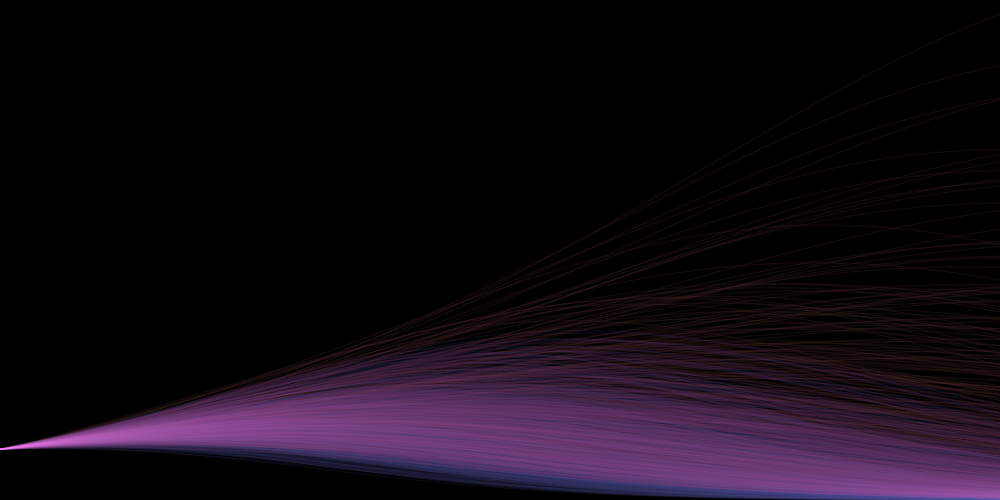

In [110]:
#build density graph
cvs = ds.Canvas(plot_height=500, plot_width=1000, x_range=x_range, y_range=y_range)
aggDensity = cvs.line(dfAll, x=timeAll, y=list(range(pointsAll)), agg=ds.count(), axis=1, line_width=1)
imgDensity = tf.shade(aggDensity, cmap=['black', '#00ff00'], how='log', min_alpha=80, alpha=255)
imgDensity = tf.set_background(imgDensity, color='black')
imgDensity = ds_to_pil_rgba(imgDensity)
imgDensity = np.asarray(imgDensity)
imgDensity = np_rgba_to_rgb(imgDensity)

# build faded graph
cvs = ds.Canvas(plot_height=500, plot_width=1000, x_range=x_range, y_range=y_range)
aggFaded = cvs.line(dfUnselected, x=timeUnselected, y=list(range(pointsUnselected)), agg=ds.count(), axis=1, line_width=1)
imgFaded = tf.shade(aggFaded, cmap=['black', '#0000ff'], how='log')
imgFaded = tf.set_background(imgFaded, color='black')
imgFaded = ds_to_pil_rgba(imgFaded)
imgFaded = np.asarray(imgFaded)
imgFaded = np_rgba_to_rgb(imgFaded)
imgFaded = np_uint8_to_float_color(imgFaded)
# imgFaded = matplotlib.colors.rgb_to_hsv(imgFaded)
# imgFaded = np.zeros_like(imgFaded, dtype=imgFaded.dtype)

# build highlighted graph
cvs = ds.Canvas(plot_height=500, plot_width=1000, x_range=x_range, y_range=y_range)
aggSelection = cvs.line(dfSelected, x=timeSelected, y=list(range(pointsSelected)), agg=ds.count(), axis=1, line_width=1)
imgSelection = tf.shade(aggSelection, cmap=['black', '#ff0000'], how='log')
imgSelection = tf.set_background(imgSelection, color='black')
imgSelection = ds_to_pil_rgba(imgSelection)
imgSelection = np.asarray(imgSelection)
imgSelection = np_rgba_to_rgb(imgSelection)
imgSelection = np_uint8_to_float_color(imgSelection)
# imgSelection = matplotlib.colors.rgb_to_hsv(imgSelection)
# imgSelection = np.zeros_like(imgSelection, dtype=imgSelection.dtype)

imgMerge = np.zeros_like(imgFaded, dtype=imgFaded.dtype)
img_float = np.empty([imgFaded.shape[0], imgFaded.shape[1], 3], dtype=np.float32)
# loop over the image pixels
for y in range(0, imgMerge.shape[0]):
    for x in range(0, imgMerge.shape[1]):
        # imgMerge[y, x, 0] = clamp_uint8(int(imgFaded[y, x, 0] + int(imgSelection[y, x, 0])))
        # imgMerge[y, x, 1] = clamp_uint8(int(imgFaded[y, x, 1] + int(imgSelection[y, x, 1])))
        # imgMerge[y, x, 2] = clamp_uint8(int(imgFaded[y, x, 2] + int(imgSelection[y, x, 2])))
        # imgMerge[y, x, 3] = clamp_uint8(255)
        if (imgFaded[y, x, 2] == imgSelection[y, x, 0]) and (imgFaded[y, x, 2] == 0):
            imgMerge[y, x, 0] = imgFaded[y, x, 2]
        else:
            imgMerge[y, x, 0] = float(imgSelection[y, x, 0]) / float(imgFaded[y, x, 2] + imgSelection[y, x, 0]) * (120/360) + (240/360)
        imgMerge[y, x, 1] = 1.0
        imgMerge[y, x, 2] = imgDensity[y, x, 1] / 255

        # if y == 419:
        #     # print('fio')
        #     if imgFaded[y, x, 2] != imgSelection[y, x, 0]:
        #         print(float(imgSelection[y, x, 0]) / float(imgFaded[y, x, 2] + imgSelection[y, x, 0]))
        #     else:
        #         print('same')
        #     imgMerge[y, x, 0] = 0.2
        #     imgMerge[y, x, 1] = 1.0
        #     imgMerge[y, x, 2] = 1.0

imgMerge = matplotlib.colors.hsv_to_rgb(imgMerge)
imgMerge = np_float_to_uint8_color(imgMerge)
imgMerge = Image.fromarray(imgMerge)
imgMerge
# combine images
# test(imgSelection)

Placeholder for histogram work.

In [109]:
import numpy as np

from bokeh.models import ColumnDataSource, Grid, LinearAxis, Plot, VBar
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

N = 9
x = np.linspace(-2, 2, N)
y = x**2

source = ColumnDataSource(dict(x=x,top=y,))
# print(dict(x=x,top=y,))

plot = Plot(
    title=None, width=500, height=100,
    min_border=0, toolbar_location=None)

glyph = VBar(x="x", top="top", bottom=0, width=0.5, fill_color="#b3de69")
plot.add_glyph(source, glyph)

output_notebook()
show(plot)
show(plot)

Loading BokehJS ...